## Prática Guiada - Bagging (diabetes)

Nesta prática vamos utilizar o dataset de diabetes que está pré-carregado na biblioteca sklearn.

O dataset consiste em 10 variáveis fisiológicas: idade, sexo, peso, pressão arterial e outras medidas em 442 pacientes e a variável target é um indicador do progresso da doença.<br>
No sklearn todas as variáveis são padronizadas, isto é, centradas na média zero e com a norma l2. <br>
Para mais informações você pode consultar o paper original <a href="http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf">aqui</a>


## 1 - BaggingClassifier

A classe BaggingClassifier do sklearn permite criar um ensemble a partir de um classificador-base. 
O método se baseia em treinar o classificador através de diferentes amostras do dataset geradas através do bootstrap e calcular a média dos resultados para reduzir a variância do estimador.

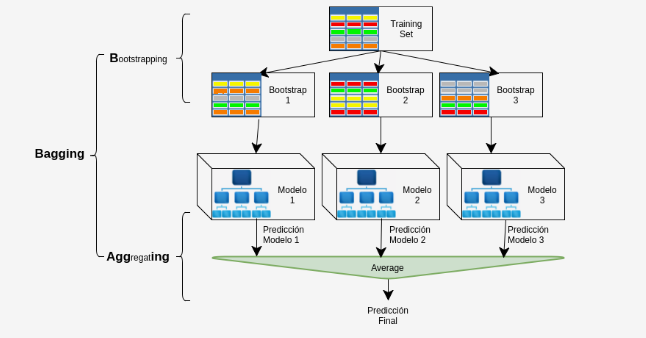

O método melhora significativamente o desempenho quando a variância do estimador de base era alta.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

data = load_diabetes()
X = data['data']
y = data['target']

In [ ]:
#Vejamos a distribuição da classe
plt.hist(y);

## Ensemble x Classificador-base

Em seguida, geramos uma função que retorna a pontuação de cross validation de cada estimador.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import KFold

def do_cross_val(model):
    my_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X, y, cv=my_fold, n_jobs=-1, scoring='r2')
    return scores.mean(), scores.std()


Vamos gerar dois classificadores para avaliar: dtr, que contém o classificador-base e bdtr, que contém o ensemble e avaliamos a média e o desvio de ambos.


In [ ]:
dtr = DecisionTreeRegressor(max_depth=2)
do_cross_val(dtr)

In [ ]:
bdtr = BaggingRegressor(DecisionTreeRegressor())
do_cross_val(bdtr)

### Mudando o número de estimadores

Agora vejamos o que acontece se mudarmos a quantidade de estimadores que incluímos no ensemble e na complexidade do modelo. A complexidade do modelo é regulada com o parâmetro max_depth que indica a profundidade da árvore. 

In [ ]:
# Definimos esta função para calcular ensembles de tamanhos diferentes no estimador que recebe. 

def calcular_scoring_stddev_bagging(basereg):
    scores=[]
    stddevs=[]
    for numreg in range(1,50):
        bdtr = BaggingRegressor(basereg,n_estimators=numreg)
        score,stddev=do_cross_val(bdtr)
        scores.append(score)
        stddevs.append(stddev)
        print (". "),
    return np.array(scores),np.array(stddevs)


In [ ]:
# Definimos as pontuações para um estimador de profundidade 1
scores_bagging_shallow,stddev_bagging_shallow=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=1))

In [ ]:
# Com o parâmetro max_depth = None, a árvore se expande até chegar a uma classificação perfeita 
# sobre os dados de treinamento.
scores_bagging_deep,stddev_bagging_deep=calcular_scoring_stddev_bagging(DecisionTreeRegressor(max_depth=None))

## Comparação de modelos

Temos, então, as pontuações de ensembles construídos com um número de estimadores que varia de 1 a 50 para três modelos de diferentes complexidades. 

Vamos representar graficamente a média e o desvio do desempenho medidos em termos de "r2"

In [ ]:
def graficar_curva(scores,stddev,color):
    x_axis=range(1,len(scores)+1)

    plt.plot(x_axis,scores,color)
    plt.plot(x_axis,stddev, color+"--")
    plt.fill_between(x_axis,scores + stddev, scores - stddev, alpha=0.1, facecolor=color)

    
plt.figure().set_size_inches(20, 10)
graficar_curva(scores_bagging_deep,stddev_bagging_deep,"r")
graficar_curva(scores_bagging_shallow,stddev_bagging_shallow,"b")
plt.ylim(0)
plt.show()


#### Interpretação do gráfico:

O modelo "simples"(azul) se desempenha melhor do que o vermelho quando há apenas um classificador. Este modelo tem muito viés por ser extremamente simples.

O modelo "complexo" (vermelho) "aprende" perfeitamente os dados de treinamento, mas tem problemas para generalizar os dados de validação. É por isso que um só classificador tem um desempenho muito ruim. É um modelo com alta variância.  

À medida que aumentamos o número de classificadores no ensemble, o modelo vermelho reduz a variância da previsão e alcança resultados melhores do que o modelo azul.

## Um dos estimadores-base, max_depth = 2


Para poder executar essas visualizações, abra um terminal e execute:

pip install pydotplus <br />
conda install graphviz


In [ ]:
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=2),n_estimators=50)
bdtr.fit(X,y)


dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
filled=True, rounded=True,special_characters=True)graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Agora vamos observar a seguinte árvore do ensemble. É parecida? É muito diferente?

In [ ]:

dot_data=export_graphviz(bdtr.estimators_[1], out_file=None,  
                
filled=True, rounded=True,special_characters=True)graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Um dos estimadores-base, max_depth = 5

Observe como quantidade de parâmetros estimados pelo modelo aumenta quando passamos de uma profundidade de 2 para uma de 5.

In [ ]:
# Aqui mostramos um dos estimadores que fazem parte do ensemble

from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

bdtr = BaggingRegressor(DecisionTreeRegressor(max_depth=5),n_estimators=50)
bdtr.fit(X,y)


dot_data=export_graphviz(bdtr.estimators_[0], out_file=None,  
                
filled=True, rounded=True,special_characters=True)graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())